In [1]:
import pandas as pd

data = pd.read_csv('prcp_monthly.csv')
data['month'] = pd.to_datetime(data['month'])
data.head()

,index,month,prcp
0,0,2001-01-01,101.400000
1,1,2001-02-01,98.200000
2,2,2001-03-01,201.200000
3,3,2001-04-01,141.200000
4,4,2001-05-01,29.233333


### 1. Check for stationary:

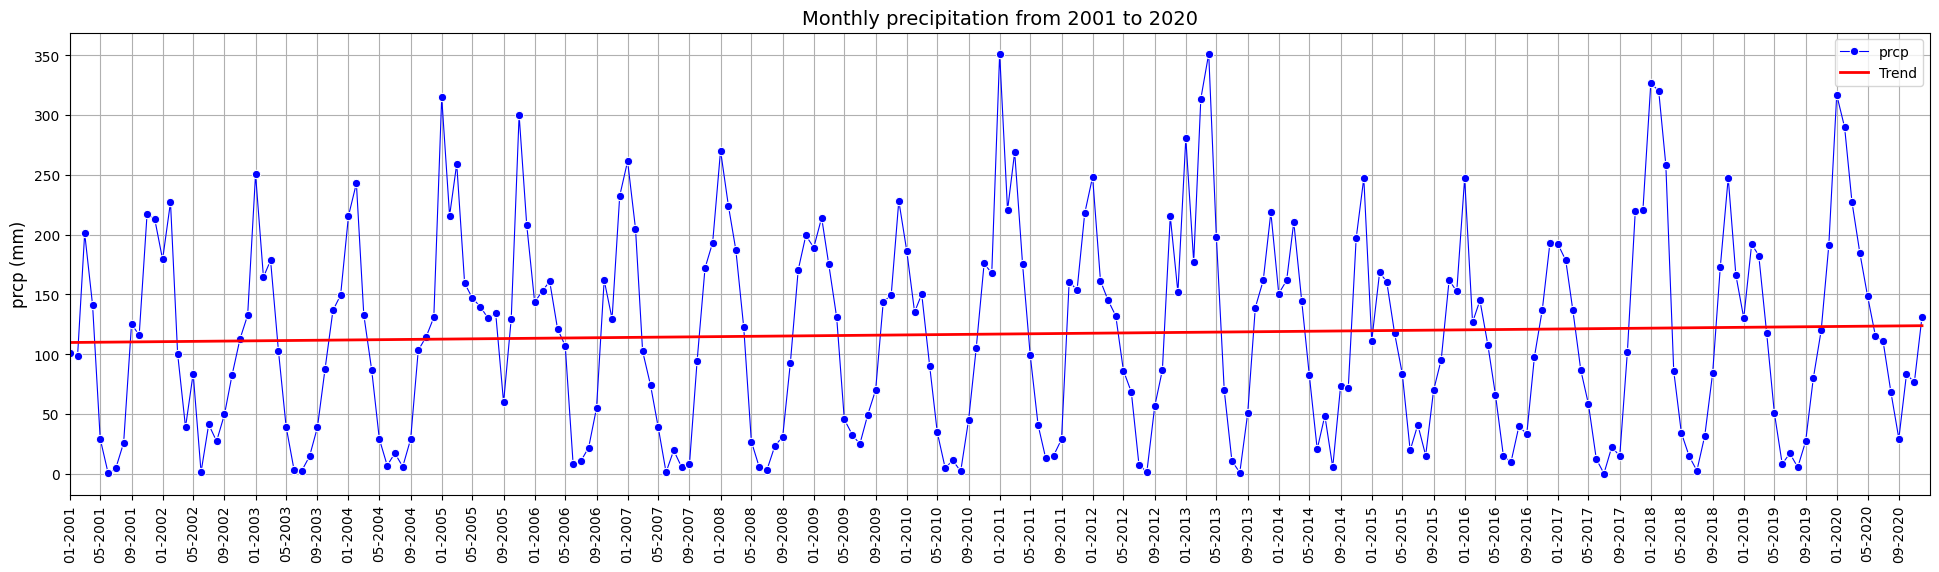

In [3]:
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

model = LinearRegression()

X = data[['index']].values
y = data['prcp'].values
model.fit(X, y)
data['trend'] = model.predict(X)

plt.figure(figsize=(24, 6))
sns.lineplot(x=data["month"], y=data["prcp"], label="prcp", color="b", linewidth=0.8, marker='o')
plt.plot(data['month'], data['trend'], color='red', linewidth=2, label='Trend')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.title("Monthly precipitation from 2001 to 2020", fontsize=14)
plt.xlabel(None)
plt.ylabel("prcp (mm)", fontsize=12)
plt.grid(True)
plt.legend()

 - There is no consistent trend (upward or downward) over the entire time span. The series appears to slowly wander up and down.
 - There are no obvious outliers.

##### Check randomness using Lag Plot:

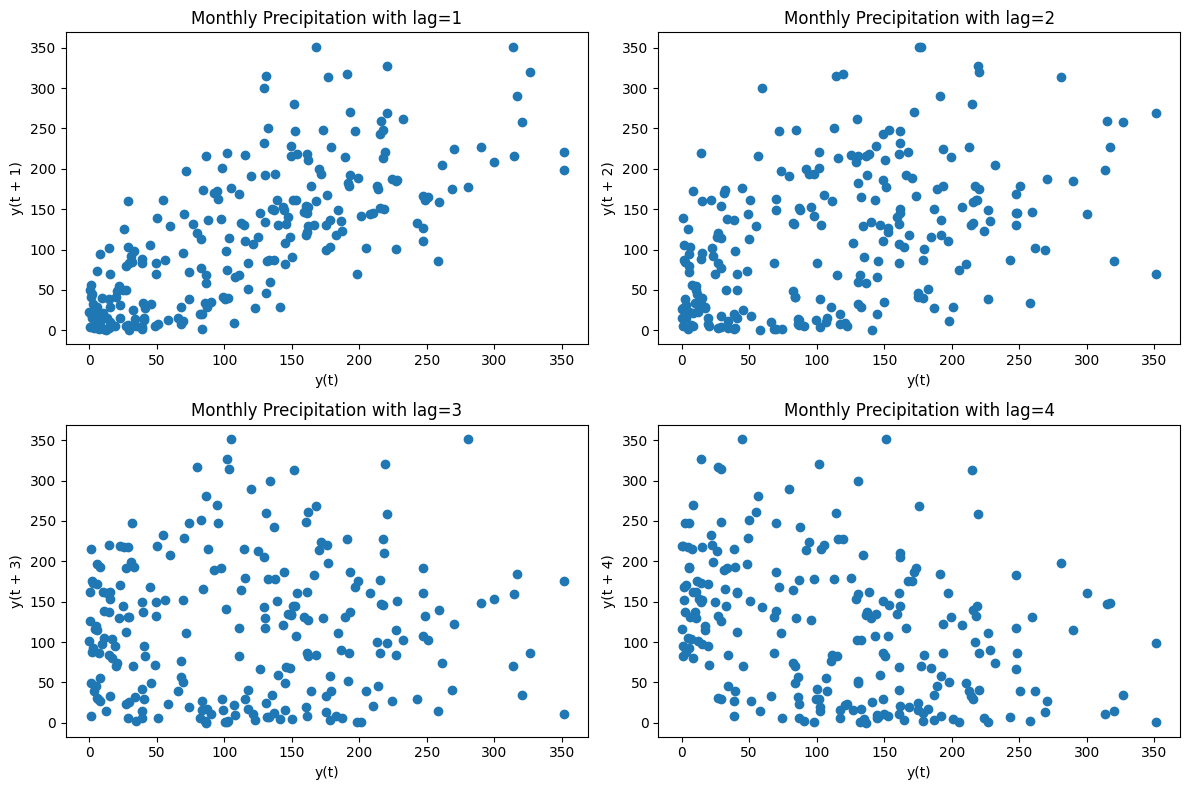

In [4]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt   

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
lag_plot(data['prcp'], lag=1)
plt.title('Monthly Precipitation with lag=1')

plt.subplot(2, 2, 2)
lag_plot(data['prcp'], lag=2)
plt.title('Monthly Precipitation with lag=2')

plt.subplot(2, 2, 3)
lag_plot(data['prcp'], lag=3)
plt.title('Monthly Precipitation with lag=3')

plt.subplot(2, 2, 4)
lag_plot(data['prcp'], lag=4)
plt.title('Monthly Precipitation with lag=4')

plt.tight_layout()
# plt.savefig('stationary_check/lag_plot.png')
plt.show()

##### Check randomness using Autocorrelation:

<Figure size 1000x600 with 0 Axes>

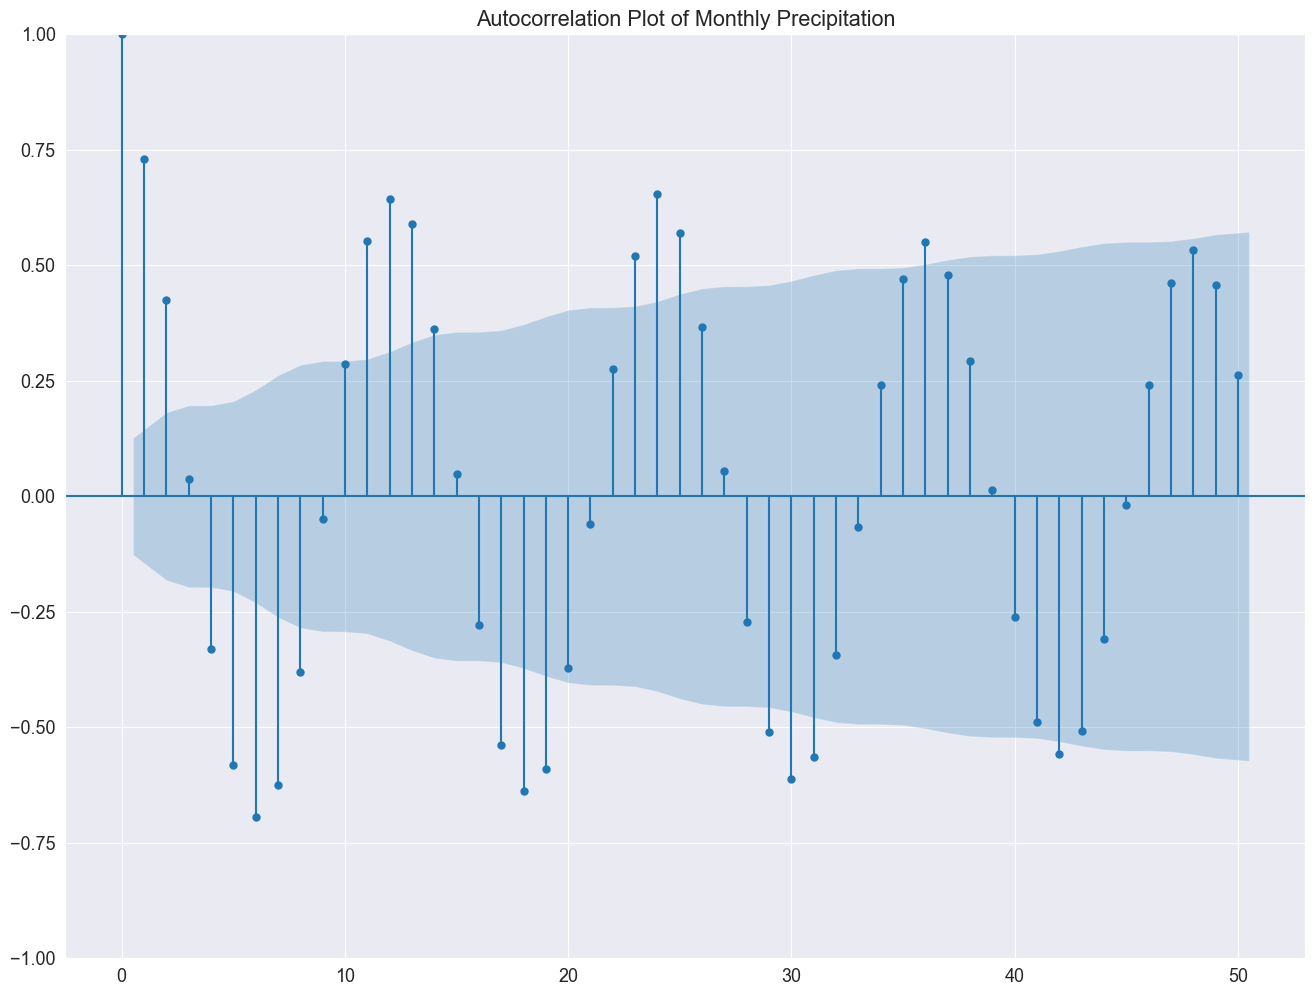

In [35]:
from statsmodels.graphics.tsaplots import plot_acf

# Vẽ autocorrelation plot với xticks tùy chỉnh
plt.figure(figsize=(10, 6))
plot_acf(data['prcp'], lags=50)

plt.title("Autocorrelation Plot of Monthly Precipitation")
# plt.savefig('station_check/auto_correlation.png')
plt.show()


- Đồ thị acf có dạng hình sin, bao gồm cả các giá trị  âm nên dữ liệu có thể bị ảnh hưởng nhiều bởi tính mùa vụ

##### ADF test:

In [5]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    print('H0: Non-stationary series')
    print('H1: Stationary series\n')
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}\n")
    if result[1] < 0.05:
        print('p-value < 0.05')
        print("-> Stationary series (Reject H₀)")
    else:
        print('p-value > 0.05')
        print(" -> Non-stationary series (Fail to Reject H₀)")

adf_test(data['prcp'])

H0: Non-stationary series
H1: Stationary series

ADF Statistic: -3.8645202899625875
p-value: 0.0023120418725554115

p-value < 0.05
-> Stationary series (Reject H₀)


##### KPPS test:

In [6]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series):
    print('H0: Stationary series')
    print('H1: Non-stationary series\n')
    result = kpss(series, regression='c', nlags='auto')
    print(f"KPSS Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("-> Non-stationary series (Reject H₀)")
    else:
        print("-> Stationary series (Fail to Reject H₀)")

kpss_test(data['prcp'])


H0: Stationary series
H1: Non-stationary series

KPSS Statistic: 0.054343197162415535
p-value: 0.1
-> Stationary series (Fail to Reject H₀)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21560\1923183154.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c', nlags='auto')


### 2. Time series decomposition:

Prepare graphics environment:

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

##### STL (Seasonal Trend decomposition using LOESS):

<Figure size 1600x1200 with 0 Axes>

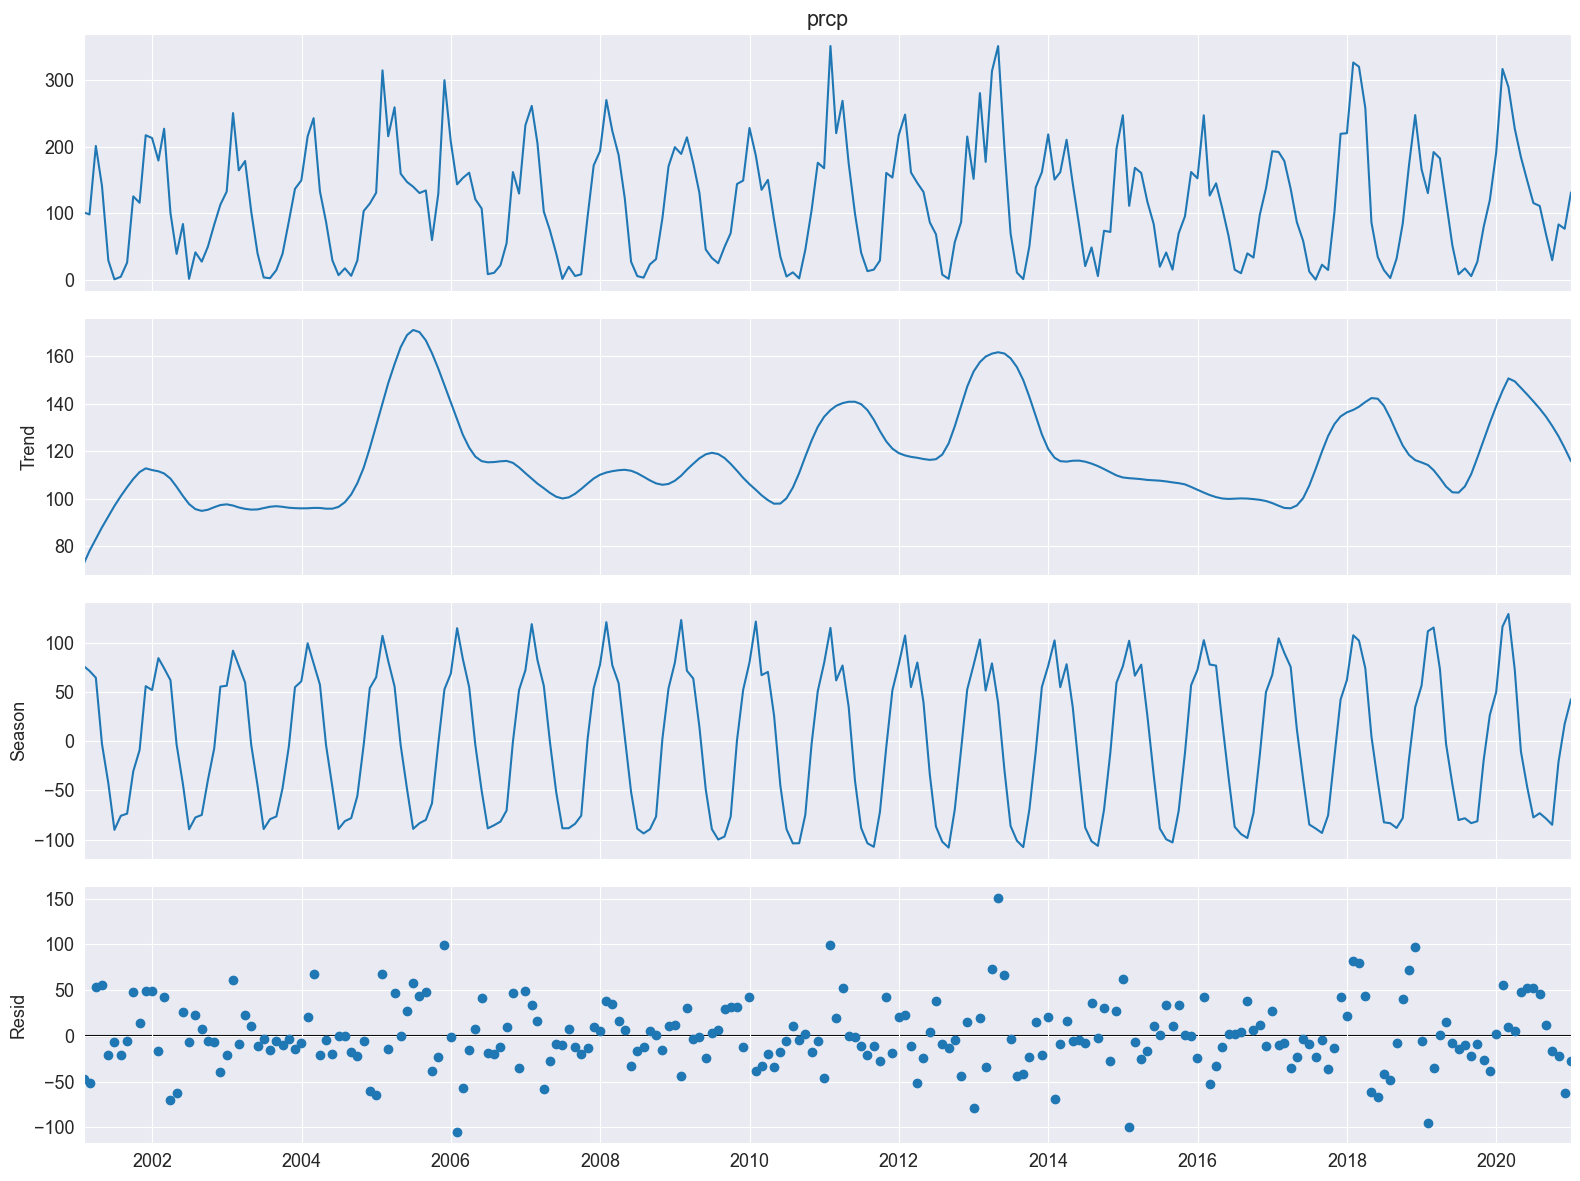

In [8]:
from statsmodels.tsa.seasonal import STL

prcp = data['prcp'].tolist()
prcp = pd.Series(prcp, index=pd.date_range(start='2001-01-01', periods=len(prcp), freq='ME'), name='prcp')
stl = STL(prcp, seasonal=13)
res = stl.fit()
plt.figure(figsize=(16, 12))
fig = res.plot()
# plt.savefig('decomposition/stl.png')

In [9]:
# relative std of trend
import numpy as np

std_trend = np.std(res.trend)
std_original = np.std(data['prcp'])

relative_std = std_trend / std_original
print(f"Relative Std: {relative_std}")

if relative_std < 0.2:
    print("Trend biến động nhẹ")
elif relative_std < 0.5:
    print("Trend biến động trung bình")
else:
    print("Trend biến động mạnh")


Relative Std: 0.22474053257533175
Trend biến động trung bình


- Thành phần mùa vụ biến động mạnh -> dữ liệu có tính mùa vụ cao
- Thành phần residual có thể có mean = 0 và tuân theo pp chuẩn

Kiểm tra tính chuẩn của Residual:

In [10]:
# Shapiro-Wilk test
from scipy.stats import shapiro

data = res.resid
stat, p = shapiro(data)
print(f"Statistic={stat}, p-value={p}")

if p > 0.05:
    print("Phần dư có thể tuân theo phân phối chuẩn")
else:
    print("Phần dư không tuân theo phân phối chuẩn")


Statistic=0.9774603579373345, p-value=0.0007212457025929535
Phần dư không tuân theo phân phối chuẩn


- Do Residual không phải nhiễu trắng nên quá trình phân tách chưa được hiệu quả

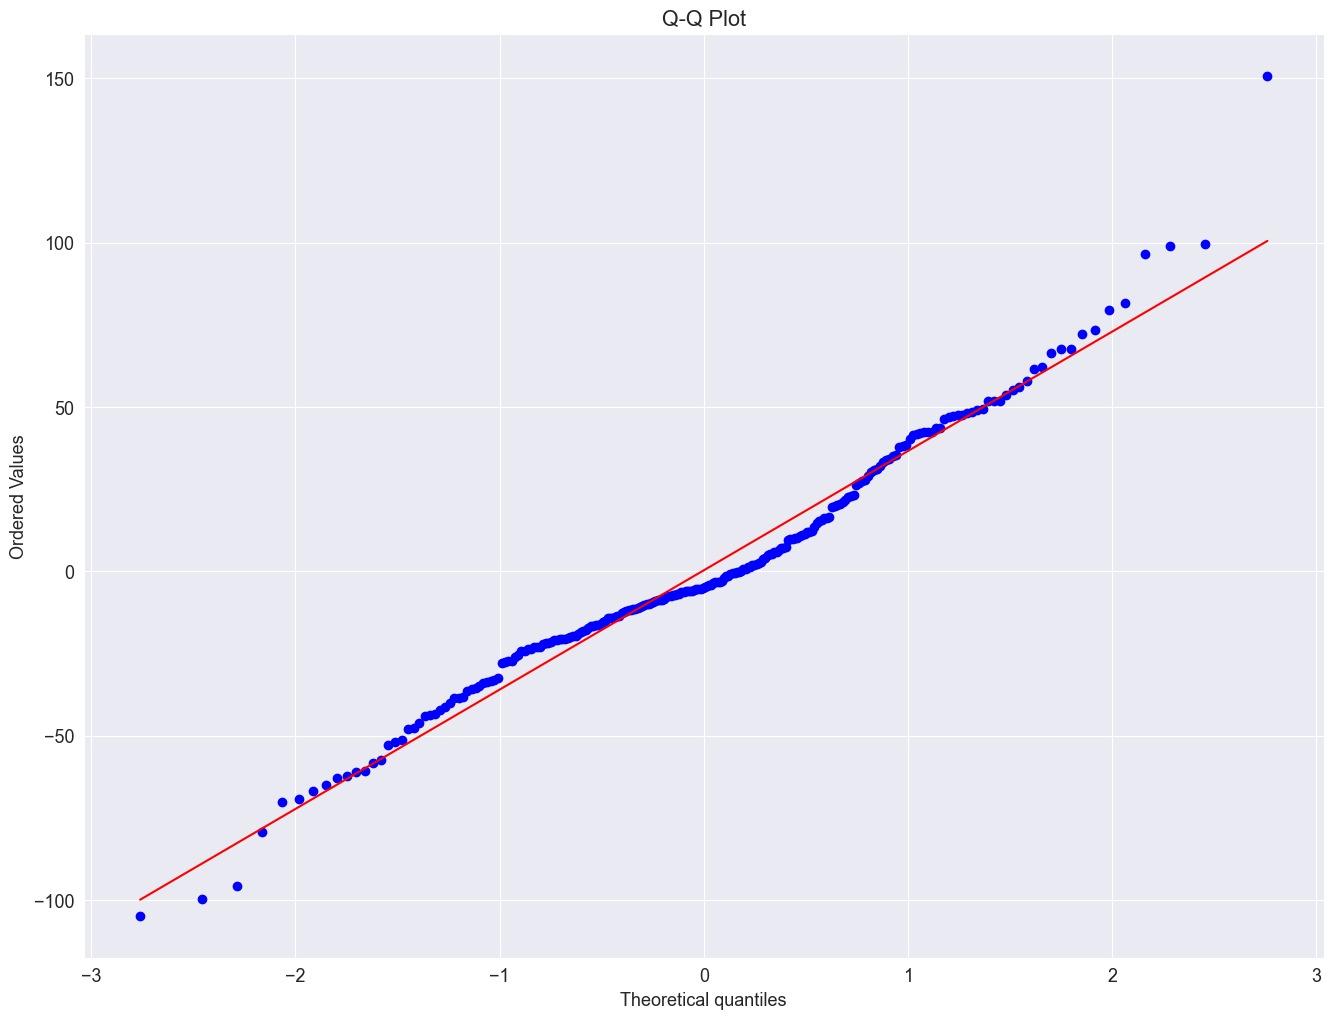

In [42]:
# qq-plot
import scipy.stats as stats

stats.probplot(data, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

- Dựa vào đánh giá trực quan trên QQ-plot, ta cũng nhân thấy pp của Residual không tuân theo pp chuẩn

##### Hodrick Prescott Filter (HPFilter) to seperate Trend and Cyclical:

In [12]:
from statsmodels.tsa.filters.hp_filter import hpfilter

prcp = data[['prcp']]
prcp.set_index(pd.date_range(start='2001-01-01', periods=len(prcp), freq='ME'), inplace=True)
cycle, trend = hpfilter(prcp['prcp'], lamb=1600)

prcp_decomp = prcp[['prcp']]
prcp_decomp["cycle"] = cycle
prcp_decomp["trend"] = trend

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
prcp_decomp[["prcp", "trend", 'cycle']]['2001-01-31':].plot(ax=ax, fontsize=14, marker='o', markersize=3)
legend = ax.get_legend()
legend.prop.set_size(20)
plt.savefig('decomposition/hp_filter.png')

KeyError: "None of [Index(['prcp'], dtype='object')] are in the [index]"